# Pizza or Not Pizza 분류(VGG Ver)
- 프로젝트에 사용된 파일

In [49]:
# 모듈 로딩
import pandas as pd
import numpy as np

from PIL import Image
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, WeightedRandomSampler


import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init
import matplotlib.pyplot as plt

# 데이터 불러오기

In [50]:
from torchvision.datasets import ImageFolder 

train_root = "../data/project_img/train" # 해당 경로 내에 있는 파일명이 곧 label이 되는 것
val_root = "../data/project_img/validation"
test_root = "../data/project_img/test"


mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

preprocessing = transforms.Compose([
    transforms.Resize((50, 50), interpolation=transforms.InterpolationMode.BILINEAR), # 1. resize
    # transforms.CenterCrop(224), # 2. 중앙크롭
    transforms.ToTensor(),  # 3. 값의 크기를 0~1로
    transforms.Normalize(mean=mean, std=std) # 4. normalized
])

trainDS = ImageFolder(root=train_root, transform=preprocessing)
valDS = ImageFolder(root=val_root, transform=preprocessing)
testDS = ImageFolder(root=test_root, transform=preprocessing)

## 데이터 셋이 잘 읽혔는지 확인

In [51]:
trainDS.classes, trainDS.class_to_idx

(['not_pizza', 'pizza'], {'not_pizza': 0, 'pizza': 1})

In [52]:
valDS.classes, valDS.class_to_idx

(['not_pizza', 'pizza'], {'not_pizza': 0, 'pizza': 1})

In [53]:
testDS.classes, testDS.class_to_idx

(['not_pizza', 'pizza'], {'not_pizza': 0, 'pizza': 1})

In [54]:
# 비율 확인
len(trainDS), len(valDS), len(testDS)

(1600, 200, 166)

In [55]:
trainDS[0][0]

tensor([[[-2.0152, -1.9980, -1.9124,  ..., -0.0116, -0.0801, -0.1828],
         [-1.8439, -1.6384, -1.3644,  ...,  0.0569,  0.0056, -0.0972],
         [-1.2445, -1.1075, -0.9877,  ...,  0.0912,  0.0569, -0.0801],
         ...,
         [-1.0733, -0.9534, -0.8164,  ...,  0.8104,  0.6049,  0.2111],
         [-1.1418, -1.0219, -0.8507,  ...,  0.8789,  0.8618,  0.8104],
         [-1.1932, -1.0562, -0.9020,  ...,  0.8961,  0.8789,  0.8618]],

        [[-1.9657, -1.9482, -1.8957,  ...,  0.1352,  0.0826, -0.0224],
         [-1.8256, -1.6331, -1.3704,  ...,  0.2227,  0.1877,  0.0826],
         [-1.2829, -1.1429, -1.0378,  ...,  0.2927,  0.2577,  0.1176],
         ...,
         [-1.0903, -0.9853, -0.8627,  ...,  1.0280,  0.8179,  0.3803],
         [-1.1429, -1.0378, -0.8978,  ...,  1.0980,  1.0630,  1.0280],
         [-1.1954, -1.0553, -0.9503,  ...,  1.1331,  1.0980,  1.0980]],

        [[-1.7173, -1.6999, -1.6302,  ...,  0.3393,  0.2871,  0.1825],
         [-1.5779, -1.3861, -1.1247,  ...,  0

In [56]:
# def make_weights(labels, nclasses):
#     labels = np.array(labels)   # where, unique 함수를 사용하기 위해 numpy로 변환한다.
#     weight_list = []   # 가중치를 저장하는 배열을 생성한다.
#  
#     for cls in range(nclasses):
#         idx = np.where(labels == cls)[0]
#         count = len(idx)    #각 클래스 데이터 수 카운트 
#         weight = 1/count    
#         weights = [weight] * count    #라벨이 뽑힐 가중치를 1/count로 동일하게 전체 라벨에 할당 
#         weight_list += weights
#  
#     return weight_list


In [57]:
# sampler -> 각 배치의 분포를 맞추기 위함 
# weights = make_weights(imgDS.targets, len(imgDS.classes))
weights = torch.ones(len(trainDS.targets), dtype=torch.float)
# print(weights)
sampler = WeightedRandomSampler(weights, len(weights))

train_DL = DataLoader(trainDS, batch_size=50, sampler=sampler)

weights = torch.ones(len(valDS.targets), dtype=torch.float)
# print(weights)
sampler = WeightedRandomSampler(weights, len(weights))
val_DL = DataLoader(valDS, batch_size=20, sampler=sampler) 
test_DL = DataLoader(testDS, batch_size=83) # 걍 통으로 레쭈꼬

# max = 10
# for cnt, (_, label) in enumerate(train_DL):
#     print(f'batch별 target 분포\n{label.bincount()}\n')
#     if cnt > max:
#         break

In [58]:
# max = 10
# for cnt, (_, label) in enumerate(val_DL):
#     print(f'batch별 target 분포\n{label.bincount()}\n')
#     if cnt > max:
#         break

In [59]:
len(train_DL), len(val_DL), len(test_DL) # 배치 개수

(32, 10, 2)

# 전이학습 VGG model 불러오기

In [60]:
### ===> 딥러닝 모델을 설계할 때 활용하는 장비 확인
if torch.cuda.is_available():
    DEVICE = torch.device('cuda')
else:
    DEVICE = torch.device('cpu')
    
print('Using PyTorch version:', torch.__version__, ' Device:', DEVICE)

Using PyTorch version: 2.2.0  Device: cpu


In [157]:
# 사전 학습된 모델 로딩
import torchvision.models as models # 다양한모델패키지
model = models.vgg16(pretrained=True)

# 사전 훈련된 모델의 파라미터 학습 유무 설정 함수
def set_parameter_requires_grad(model, feature_extract = True):
    if feature_extract:
        for param in model.parameters():
            param.requires_grad = False # 학습하는 것을 방지

set_parameter_requires_grad(model) # 함수 호출

In [158]:
# 분류기 부분을 이진 분류기로 수정하는 클래스 정의
class BinaryClassifier(nn.Module):
    def __init__(self):
        super(BinaryClassifier, self).__init__()
        # VGG16의 특성 추출기 부분만 가져오기
        self.features = model.features
        # VGG16의 특성 추출기의 출력 크기 계산
        self.num_features = 512 * 1 * 1  # VGG16은 입력 이미지를 224x224 크기로 처리하므로, 여기서는 1x1로 출력됩니다.
        
        # 이진 분류를 위한 새로운 fully connected layer 정의
        self.fc = nn.Sequential(
            nn.Linear(self.num_features, 4096),  # 특성 추출기의 출력 크기를 입력으로 받음
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(4096, 1),  # 이진 분류를 위한 출력 뉴런 수
            nn.Sigmoid()  # 이진 분류를 위한 시그모이드 활성화 함수
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # flatten
        x = self.fc(x)
        return x

# 모델 생성
model = BinaryClassifier()

# 특성 추출기 부분의 파라미터를 고정시킴
set_parameter_requires_grad(model)

# 모델 구조 확인
print(model)

BinaryClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [159]:
for param in model.fc.parameters(): # 완전연결층은학습
    param.requires_grad = True

위 코드에서 BinaryClassifier 클래스는 VGG16의 특성 추출기 부분을 가져와서 이진 분류를 위한 새로운 fully connected layer를 추가하여 이진 분류기로 만듭니다. set_parameter_requires_grad 함수를 사용하여 특성 추출기 부분의 파라미터를 고정시킵니다. 이렇게 하면 특성 추출기 부분은 사전 훈련된 가중치를 고정시키고, 분류기 부분만 새로 훈련됩니다.

In [160]:
model.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('features',
               Sequential(
                 (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                 (1): ReLU(inplace=True)
                 (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                 (3): ReLU(inplace=True)
                 (4): MaxPool2d(kernel_size=2, stride=2, padding=0

In [161]:

#################
optimizer = torch.optim.Adam(model.fc.parameters()) # fc인 것이 중요!!
criterion = nn.BCELoss() # 손실 함수 정의
print(model)

BinaryClassifier(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=

In [162]:
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=[2, 3, 4, 8, 13, 18, 25, 30], gamma=0.5)

In [163]:
# CNN 모델 학습 진행 함수
def train(epoch, model, train_loader, optimizer, log_interval):
    model.train()
    total_loss = 0
    correct = 0
    
    for batch_idx, (image, label) in enumerate(train_loader):
        image = image.to(DEVICE)
        label = label.to(DEVICE)
        # label = label.unsqueeze(dim=1).dtype(torch.)
        
        optimizer.zero_grad()
        output = model(image)
        label = label.float()
        
        loss = criterion(output, label.unsqueeze(dim = 1))
        loss.backward()
        optimizer.step()
        scheduler.step() # 스케줄러 
        
        total_loss += criterion(output, label.unsqueeze(dim = 1)).item()
        prediction = output.round()
        correct += prediction.eq(label.view_as(prediction)).sum().item()
        
        if batch_idx % log_interval == 0:
            print(f"Train Epoch: {epoch} [{batch_idx}]\tTrain Loss: {loss.item():.6f}")
            
    total_loss /= len(train_loader.dataset) # 평균 손실 
    train_accuracy = 100. * correct / len(train_loader.dataset)
    return total_loss, train_accuracy
    

In [164]:
model.__dict__

{'training': True,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_non_persistent_buffers_set': set(),
 '_backward_pre_hooks': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_is_full_backward_hook': None,
 '_forward_hooks': OrderedDict(),
 '_forward_hooks_with_kwargs': OrderedDict(),
 '_forward_hooks_always_called': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_forward_pre_hooks_with_kwargs': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_load_state_dict_post_hooks': OrderedDict(),
 '_modules': OrderedDict([('features',
               Sequential(
                 (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                 (1): ReLU(inplace=True)
                 (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                 (3): ReLU(inplace=True)
                 (4): MaxPool2d(kernel_size=2, stride=2, padding=0

In [165]:
### 검증 validation 진행 함수 
def evaluate(model, val_loader):
    model.eval()
    test_loss = 0
    correct = 0

    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            label = label.float()
            output = model(image)
            test_loss += criterion(output, label.unsqueeze(dim = 1)).item()
            # print(output.max(1, keepdim = True))
            prediction = output.round()  # 이진 분류에서는 반올림하여 0 또는 1로 변환
            # print(label)
            # print(prediction)
            # print(prediction.eq(label.view_as(prediction)).sum().item())
            # print()
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_loss /= len(val_loader.dataset) # 평균 손실 
    test_accuracy = 100. * correct / len(val_loader.dataset)
    return test_loss, test_accuracy

In [166]:
len(val_DL.dataset)

200

# 학습 진행

In [171]:
# CNN 학습
EPOCHS = 100

# 최고 성능 모델의 가중치 저장
best_model_weights = None
best_test_loss = np.inf
patience = 10  # 조기 종료를 위한 참을성 값 설정
counter = 0  # 성능이 향상되지 않는 epoch 카운터

train_loss_acc = [[],[]]
val_loss_acc = [[],[]]

for epoch in range(1, EPOCHS + 1):
    
    train_loss, train_acc = train(epoch, model, train_DL, optimizer, log_interval=200)
    train_loss_acc[0].append(train_loss)
    train_loss_acc[1].append(train_acc)
    
    
    test_loss, test_accuracy = evaluate(model, val_DL)
    print(f"\n[EPOCH: {epoch}], \tTest Loss: {test_loss:.4f}, \tTest Accuracy: {test_accuracy:.2f} % \n")
    val_loss_acc[0].append(test_loss)
    val_loss_acc[1].append(test_accuracy)
    
    # 조기 종료 검사
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        best_model_weights = model.state_dict()  # 최고 성능 모델의 가중치 저장
        counter = 0  # 카운터 초기화
    else:
        counter += 1  # 성능이 향상되지 않음
        
        if counter >= patience:
            print("조기 종료: 검증 손실이 이전에 관측된 최적의 손실보다 높아짐")
            break
            
# 최고 성능 모델의 가중치로 모델을 업데이트
if best_model_weights is not None:
    model.load_state_dict(best_model_weights)

Train Epoch: 1 [0]	Train Loss: 0.260696

[EPOCH: 1], 	Test Loss: 0.0171, 	Test Accuracy: 86.00 % 
Train Epoch: 2 [0]	Train Loss: 0.498207

[EPOCH: 2], 	Test Loss: 0.0212, 	Test Accuracy: 80.00 % 
Train Epoch: 3 [0]	Train Loss: 0.311067

[EPOCH: 3], 	Test Loss: 0.0140, 	Test Accuracy: 89.50 % 
Train Epoch: 4 [0]	Train Loss: 0.212476

[EPOCH: 4], 	Test Loss: 0.0181, 	Test Accuracy: 84.00 % 
Train Epoch: 5 [0]	Train Loss: 0.210519

[EPOCH: 5], 	Test Loss: 0.0169, 	Test Accuracy: 87.00 % 
Train Epoch: 6 [0]	Train Loss: 0.338630

[EPOCH: 6], 	Test Loss: 0.0143, 	Test Accuracy: 87.00 % 
Train Epoch: 7 [0]	Train Loss: 0.355682

[EPOCH: 7], 	Test Loss: 0.0143, 	Test Accuracy: 90.00 % 
Train Epoch: 8 [0]	Train Loss: 0.356201

[EPOCH: 8], 	Test Loss: 0.0188, 	Test Accuracy: 81.50 % 
Train Epoch: 9 [0]	Train Loss: 0.288365

[EPOCH: 9], 	Test Loss: 0.0123, 	Test Accuracy: 91.50 % 
Train Epoch: 10 [0]	Train Loss: 0.234353

[EPOCH: 10], 	Test Loss: 0.0147, 	Test Accuracy: 88.50 % 
Train Epoch: 11 [0

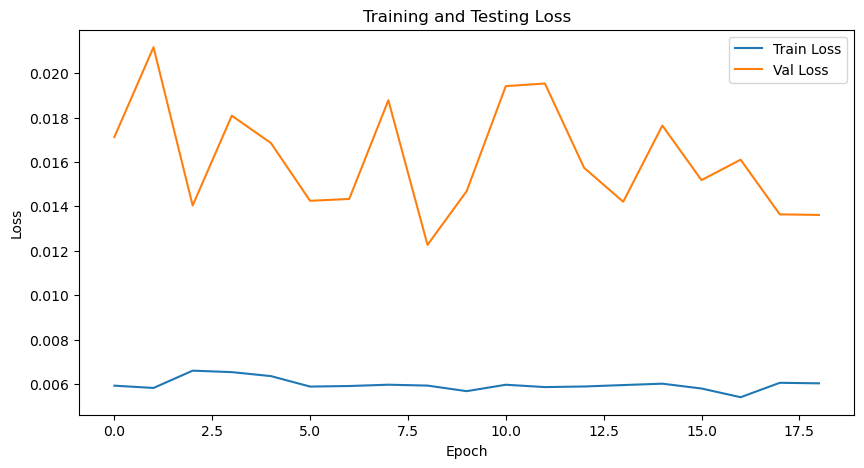

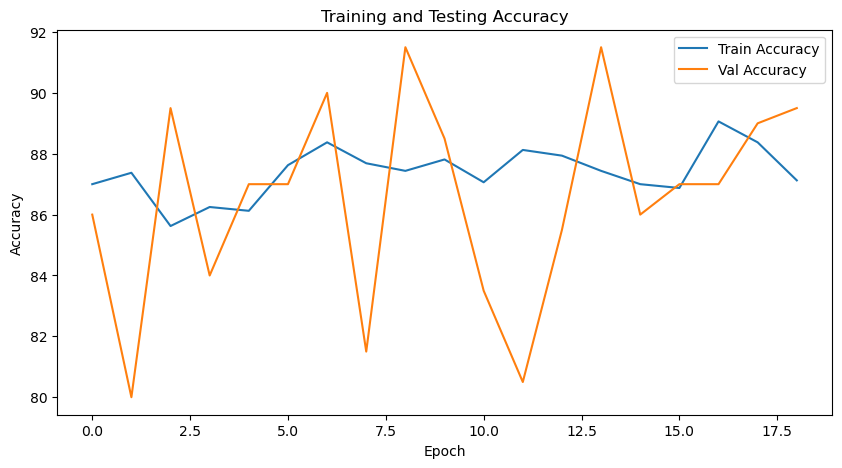

In [172]:
# Loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[0], label='Train Loss')
plt.plot(val_loss_acc[0], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss')
plt.legend()
plt.show()

# Accuracy 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[1], label='Train Accuracy')
plt.plot(val_loss_acc[1], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Testing Accuracy')
plt.legend()
plt.show()

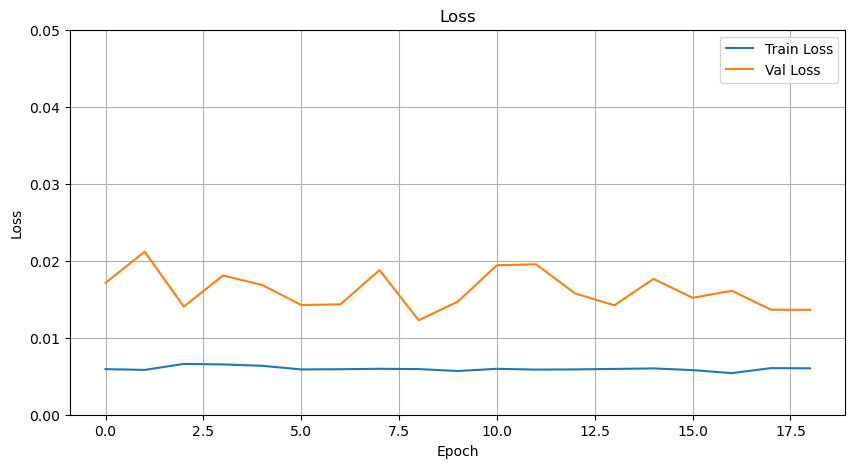

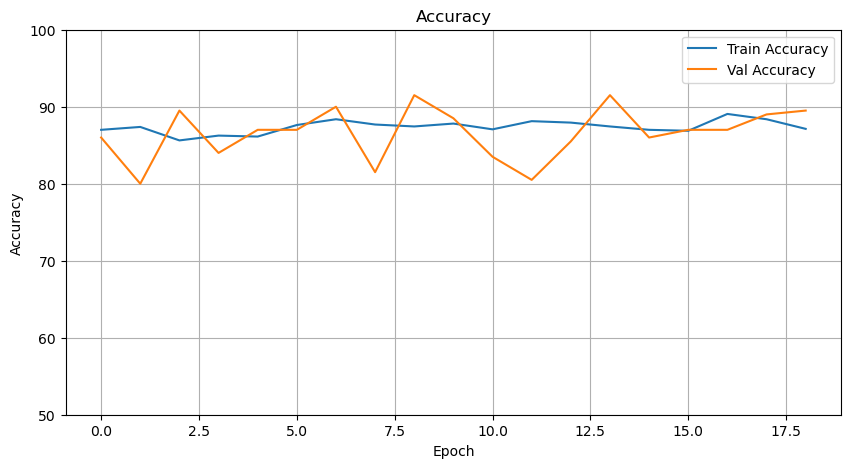

In [184]:
# Loss 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[0], label='Train Loss')
plt.plot(val_loss_acc[0], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.ylim(0, 0.05)
plt.grid()
plt.legend()
plt.show()

# Accuracy 그래프 그리기
plt.figure(figsize=(10, 5))
plt.plot(train_loss_acc[1], label='Train Accuracy')
plt.plot(val_loss_acc[1], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend()
plt.grid()
plt.ylim(50, 100)
plt.show()

# test data predict

In [173]:
def predict(model, val_loader):
    model.eval()
    correct = 0

    with torch.no_grad():
        for image, label in val_loader:
            image = image.to(DEVICE)
            label = label.to(DEVICE)
            label = label.float()
            output = model(image)
            # print(output.max(1, keepdim = True))
            prediction = output.round()  # 이진 분류에서는 반올림하여 0 또는 1로 변환
            
            correct += prediction.eq(label.view_as(prediction)).sum().item()
    
    test_accuracy = 100. * correct / len(val_loader.dataset)
    return test_accuracy

predict(model, test_DL)

85.5421686746988

In [174]:
torch.save(model.state_dict(), 'model_VGG16.pth')